### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import pyro

%matplotlib inline

In [125]:
al = imp.reload(al)

In [2]:
######## SET PARAMS ##########
batch_size = 8
start_size = 64

##############################

# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Get loaders and initial indices
# loaders, init_idx, unlab_idx = al.setup_data_loaders(batch_size=batch_size, starting_size=start_size,\
#                                                      use_cuda=False)
# train_loader, unlab_loader, val_loader, test_loader = loaders

In [3]:
# Get x/y split for the validation and test sets 
test_x,test_y = al.get_xy_split(test_loader)


### Idea:

You start with 64 random points to make a model. Then you get to choose 16 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [90]:
def get_dataset_split(train_set, other_size=10000, random_seed=1992):
    np.random.seed(random_seed)
    if isinstance(train_set, tuple):
#         print(train_set[0].size(),train_set[0][0].size())
        msk = np.random.choice(range(len(train_set[1])),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in msk])
        y1_tensor = torch.LongTensor([train_set[1][i] for i in msk])
        x2_tensor = torch.cat([train_set[0][i].view(-1,28,28) for i in range(len(train_set[1])) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[1][i] for i in range(len(train_set[1])) if i not in msk])
    else:
        msk = np.random.choice(range(len(train_set)),size=other_size, replace=False)
        x1_tensor = torch.cat([train_set[i][0] for i in msk])
        y1_tensor = torch.LongTensor([train_set[i][1] for i in msk])
        x2_tensor = torch.cat([train_set[i][0] for i in range(len(train_set)) if i not in msk])
        y2_tensor = torch.LongTensor([train_set[i][1] for i in range(len(train_set)) if i not in msk])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor

train_x, train_y, val_x, val_y = get_train_split(train_set)

In [63]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return nn.functional.log_softmax(x.view(-1,self.classes),dim=1)


50000

test_acc 0.1314


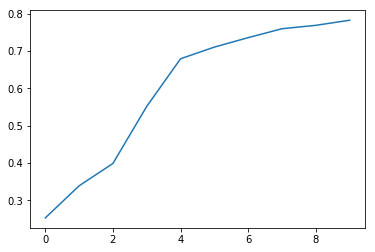

In [238]:
model = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

def train_(model, train_x, train_y, loss_func, optimizer, epochs=10, batch_size=8):
    losses,itrs = [],0
    tensor_dataset = torch.utils.data.dataset.TensorDataset(train_x,train_y)
    tr_loader = torch.utils.data.DataLoader(dataset=tensor_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for i,(batch_x,batch_y) in enumerate(tr_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])

    return list(range(itrs)), losses

def active_learn(model, train_x, train_y, policy, loss_func, optimizer, val_x, val_y, \
                 epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10):
    """ Active learning based on a specified policy. """
    # initialy train the model and then based on unlabeled results use the policy to choose more points ans iterate
    total_acc = []
    unlab_x,unlab_y,lab_x,lab_y = get_dataset_split((train_x,train_y), other_size=npoints, \
                                                  random_seed=832)

    for e in range(meta_epochs):
        # Train the model
        itr, losses = train_(model, lab_x, lab_y, loss_func, optimizer, epochs=epochs_per_train, \
                             batch_size=batch_size)
        
        # Get the next points to label 
        unlab_x,unlab_y, addtl_x, addtl_y = get_req_points(model, unlab_x, unlab_y, policy=policy, n=16)
        lab_x, lab_y = torch.cat([lab_x, addtl_x]), torch.cat([lab_y, addtl_y])
 
        # Get accuracy of the model 
        total_acc.append(al.accuracy(model,val_x,val_y))
        
    return list(range(meta_epochs)), total_acc


def get_req_points(model, unlab_x, unlab_y, policy='random', n=16):
    if policy!='random':
        pred_y = model.forward(Variable(unlab_x))
        if policy=='boundary':
            fn = boundary_policy
        elif policy=='uniform':
            fn = uniform_policy
        elif policy=='max_entropy':
            fn = max_entropy_policy
        elif policy=='conf':
            fn = least_confidence_policy
        idxs = fn(pred_y, n=n)
        new_u_x, new_u_y, add_x, add_y = get_idx_split(unlab_x, unlab_y, idxs)
    else: 
        new_u_x, new_u_y, add_x, add_y = get_dataset_split((unlab_x,unlab_y), other_size=n, random_seed=13)
    return new_u_x, new_u_y, add_x, add_y

def boundary_policy(pred_y, n):
    result = al.boundary_proximity(pred_y, num_points=n)
#     print(result)
    return result

def get_idx_split(data_x, data_y, idx):
    x1_tensor = torch.cat([data_x[i].view(-1,28,28) for i in idx])
    y1_tensor = torch.LongTensor([data_y[i] for i in idx])
    x2_tensor = torch.cat([data_x[i].view(-1,28,28) for i in range(len(data_y)) if i not in idx])
    y2_tensor = torch.LongTensor([data_y[i] for i in range(len(data_y)) if i not in idx])
    return x2_tensor, y2_tensor, x1_tensor, y1_tensor

def max_entropy_policy(pred_y, n):
    """ Source of math: https://www.cs.cmu.edu/~tom/10701_sp11/recitations/Recitation_13.pdf """
#     print(pred_y.size())
#     print(pred_y)
    probs = torch.exp(pred_y.data)
#     print(probs.size())
#     print(probs)
#     prob_logprob = np.multiply(probs, np.log2(probs))
    prob_logprob = probs*pred_y.data
#     print(prob_logprob.size())
#     print(prob_logprob)
    max_ent = -torch.sum(prob_logprob, dim=1)
#     print(max_ent)
#     print(torch.max(max_ent,0))
#     print(np.max(max_ent.numpy()))
#     print(np.argmax(max_ent))
    max_ent_idxs = al.n_argmax(max_ent, size=n)
#     print(max_ent_idxs)
    return max_ent_idxs

def least_confidence_policy(pred_y, n):
#     maxes = torch.max(torch.exp(pred_y.data),1)[0]
    maxes = torch.max(pred_y.data,1)[0]
#     print(maxes)
    least_conf = 1.0-maxes
    least_conf_idx = al.n_argmax(least_conf, size=n)
    return least_conf_idx

def uniform_policy(pred_y, n):
    cut = n%10
    times = n//10
    _,preds = torch.max(pred_y,dim=1)
    output = []
    for res in range(10): # number of classes
        pred_idx = [idx for idx, elm in enumerate(preds) if elm.data.numpy()[0] == res]
        if len(pred_idx) < (times+1):
            if res<cut:
                output.extend(np.random.choice(range(len(preds)),size=times+1))
            else:
                output.extend(np.random.choice(range(len(preds)),size=times))
            continue
        if res<cut:
            output.extend(np.random.choice(pred_idx, size=times+1))
        else:
            output.extend(np.random.choice(pred_idx, size=times))
    return np.array(output)
    
# itr, acc = train_(model,train_x,train_y)
# itr, acc = train_(model,train_x[:16],train_y[:16],loss_func, optimizer)
# res = get_req_points(model, train_x, train_y, policy='max_entropy', n=16)
rrr = get_req_points(model, train_x, train_y, policy='conf', n=16)
# it, ac = active_learn(model, train_x, train_y, 'boundary', loss_func, optimizer, val_x, val_y, \
#                  epochs_per_train=10, npoints=16, batch_size=8, meta_epochs=10)
plt.plot(it,ac)
print('test_acc',al.accuracy(model,test_x,test_y))

In [151]:
def plot_al_results(meta_epochs, accs, labs): 
    itrs = np.array(list(range(meta_epochs)))
    means, errs = [], []
    for ac in accs:
        means.append(np.mean(ac, axis=0))
        errs.append(np.std(ac,axis=0))

    plt.figure(figsize=(8,8))
    for ac_mean, ac_err, ac_lab in zip(means, errs, labs):
        plt.plot(itrs, ac_mean, label=ac_lab)
        plt.fill_between(itrs, ac_mean+ac_err, ac_mean-ac_err, alpha=0.4)

    plt.title('Accuracy of various active learning policies.')
    plt.xlabel('Meta Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    sns.despine()

In [253]:
########### GLOBAL EXPERIMENT PARAMS ############
# Epochs of adding additional points
meta_epochs = 100
# Epochs per training run
ept = 5
# Number of points to start with and add each run 
npoints = 16
batch_size = 8
learning_rate = 0.01
# Number of runs to create a sampling distribution to quantify error 
samp_runs = 10

#################################################

def try_policy(policy, meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs):
    # general policy test 
    try_acc = []
    for i in tqdm(range(samp_runs)):
        model_try = logreg(classes=10)
        optimizer_try = optim.SGD(model_try.parameters(), lr=learning_rate)
        _, acc = active_learn(model_try, train_x, train_y, policy, loss_func, optimizer_try, \
                                            val_x, val_y, epochs_per_train=ept, npoints=npoints, \
                                            batch_size=batch_size, meta_epochs=meta_epochs)
        try_acc.append(acc)
    print(f'Active Learning with {policy} policy done!')
    return try_acc


random_acc = try_policy('random', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
boundary_acc = try_policy('boundary', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
entropy_acc = try_policy('max_entropy', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
confidence_acc = try_policy('conf', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)
uniform_acc = try_policy('uniform', meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs)

A Jupyter Widget


Active Learning with random policy done!


A Jupyter Widget


Active Learning with boundary policy done!


A Jupyter Widget


Active Learning with max_entropy policy done!


A Jupyter Widget


Active Learning with conf policy done!


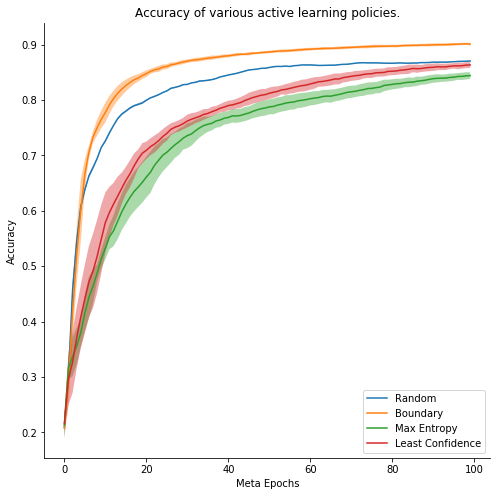

In [254]:
accs = [random_acc,boundary_acc,entropy_acc, confidence_acc]#,uniform_acc]
labs = ['Random','Boundary','Max Entropy', 'Least Confidence']#,'Uniform']
plot_al_results(meta_epochs,accs,labs)

In [ ]:
# add cluster policy?
# get max entropy and least confidence working

In [237]:
# print(torch.sum(torch.exp(model_bound(Variable(test_x))),dim=1))
# print(torch.sum(nn.functional.softmax(model_bound(Variable(test_x)),dim=1),dim=1))
# print(torch.sum(nn.functional.softmax(nn.functional.softmax(model_bound(Variable(test_x)),dim=1),dim=1),dim=1))
print(torch.exp(model_bound(Variable(test_x)))[0])
sft = nn.functional.softmax(model_bound(Variable(test_x)),dim=1)
print(sft[0])
print(nn.functional.softmax(sft,dim=1)[0])

Variable containing:
 0.0014
 0.0000
 0.0004
 0.0018
 0.0008
 0.0017
 0.0001
 0.9858
 0.0014
 0.0067
[torch.FloatTensor of size 10]

Variable containing:
 0.0014
 0.0000
 0.0004
 0.0018
 0.0008
 0.0017
 0.0001
 0.9858
 0.0014
 0.0067
[torch.FloatTensor of size 10]

Variable containing:
 0.0856
 0.0855
 0.0855
 0.0857
 0.0856
 0.0857
 0.0855
 0.2292
 0.0856
 0.0861
[torch.FloatTensor of size 10]

